# Lab 6: Optimizing FNNs with Keras
COSC 410: Applied Machine Learning\
Colgate University\
*Prof. Apthorpe*

This lab is due to Gradescope by the beginning of lab next week (2:45p on 3/10). You may work with a partner on this lab – if you do, submit only one solution as a “group” on Gradescope.

## Introduction

The purpose of this lab is for you to practice creating *and improving* feedforward networks. Upon completing this lab, you should be comfortable using the `Functional` API for creating networks, optimizing FNN hyperparameters, implementing overfitting reduction techniques, and identifying misclassified examples.

We will be using a new dataset, `rock_paper_scissors`, a collection of 300x300 pixel images of hands showing the symbol for "rock" (closed fist), "paper" (open hand), or "scissors" (two fingers in a "V"). The goal will be to train a model that can detect the symbol a hand is showing.

## Provided Files
 * `Lab6.ipynb`: This file
 
## Part 1: Data Import and Exploration

The following cell imports all needed libraries and loads the `rock_paper_scissors` dataset. 

**Note:** You will need to run `pip3 install ipywidgets tensorflow-datasets` *from within your virtual environment* and then restart Jupyter Lab before running the following cell.

In [50]:
import numpy as np
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras as ks
import tensorflow as tf
from sklearn import metrics, model_selection
np.random.seed(0), tf.random.set_seed(1)

# load data and cache for future use
train_images, train_labels = tfds.as_numpy(tfds.load('rock_paper_scissors', split='train', batch_size=-1, as_supervised=True, shuffle_files=True))
test_images, test_labels = tfds.as_numpy(tfds.load('rock_paper_scissors', split='test', batch_size=-1, as_supervised=True, shuffle_files=True))

# convert images to grayscale
train_images = train_images.mean(axis=3)
test_images = test_images.mean(axis=3)

# create a validation set
train_images, val_images, train_labels, val_labels = model_selection.train_test_split(train_images, train_labels, test_size=0.15, shuffle=True)

# print dataset shape
print(train_images.shape)
print(val_images.shape)
print(test_images.shape)
print()

# print counts of examples in each class
print(np.unique(train_labels, return_counts=True)[1])
print(np.unique(val_labels, return_counts=True)[1])
print(np.unique(test_labels, return_counts=True)[1])

(2142, 300, 300)
(378, 300, 300)
(372, 300, 300)

[719 712 711]
[121 128 129]
[124 124 124]


The following cell defines a function for plotting multiple images side-by-side and then plots the first 10 examples in the training set:

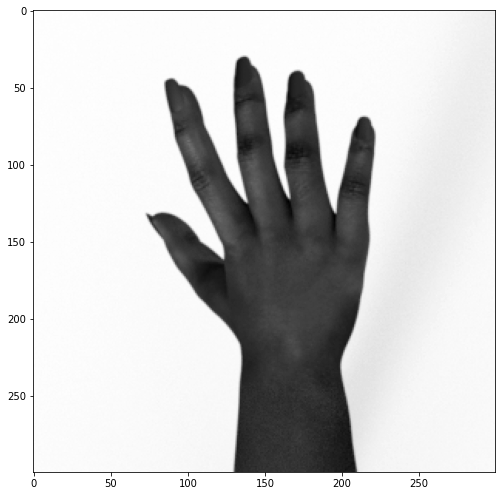

In [58]:
def plot_images(images):
    fig = plt.figure(tight_layout='auto', figsize=(20, 7))
    for i, img in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img, cmap="gray")
    return fig

plot_images(train_images[0:10])
pass

## Part 2: FNN Creation, Training, and Optimization

Your task is to create the best FNN model you can to make "rock paper scissors" predictions.

There are a few rules:

0. You must use the **Functional API** to create the models
1. You must try at least 3 different architectures with different numbers of hidden layers and different numbers of nodes per layer
2. You must try the following methods of reducing overfitting
    * Dropout OR Regularization
    * Training set augmentation
3. You must try at least 2 different values for each of 2 different hyperparameters from the following list:
    * Kernel initializer 
    * Dropout rate
    * Regularization penalty
4. You must NOT train on the test data (only use the training and validation data for this part of the lab)

This means that you will be performing at least 9 different model creation and trainings with the goal of selecting the model with the best **validation** accuracy. Note that you can tell `.fit()` what validation data to use with the keyword argument `validation_data=(val_images, val_labels)` INSTEAD of using `validation_split`. 

Place the code for each of these model creation and training attempts into separate cells below. 

In [31]:
# Model 1 - L2 regularizer 0.001
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.001))(norm_layer)
h2 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.001))(h1)
h3 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.001))(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")


Epoch 1/30
22/22 [==============================] - 6s 257ms/step - loss: 8.4749 - accuracy: 0.7913 - val_loss: 8877.3779 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 5s 247ms/step - loss: 2.3338 - accuracy: 0.9454 - val_loss: 3634.0261 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 6s 260ms/step - loss: 2.1938 - accuracy: 0.9304 - val_loss: 2614.3040 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 5s 246ms/step - loss: 1.2381 - accuracy: 0.9692 - val_loss: 883.7515 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 5s 239ms/step - loss: 1.3043 - accuracy: 0.9697 - val_loss: 3121.8052 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 6s 264ms/step - loss: 1.0814 - accuracy: 0.9809 - val_loss: 665.7486 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 5s 237ms/step - loss: 1.6305 - accuracy: 0.9757 - val_loss: 646.8691 - val_accur

In [32]:
# Model 2 - L2 regularizer 0.005
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.005))(norm_layer)
h2 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.005))(h1)
h3 = ks.layers.Dense(128, activation='relu', kernel_regularizer=ks.regularizers.l2(0.005))(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 6s 258ms/step - loss: 10.4819 - accuracy: 0.7923 - val_loss: 3696.0188 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 5s 244ms/step - loss: 3.5164 - accuracy: 0.9127 - val_loss: 1675.0052 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 5s 237ms/step - loss: 2.6081 - accuracy: 0.9468 - val_loss: 5407.1318 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 5s 237ms/step - loss: 2.0626 - accuracy: 0.9594 - val_loss: 1379.9451 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 5s 234ms/step - loss: 2.0577 - accuracy: 0.9496 - val_loss: 3501.3799 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 5s 236ms/step - loss: 1.5404 - accuracy: 0.9781 - val_loss: 866.7911 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 5s 233ms/step - loss: 1.6714 - accuracy: 0.9594 - val_loss: 1065.7369 - val_ac

In [33]:
# Model 3 - Kernel initializer he_normal
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(norm_layer)
h2 = ks.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(h1)
h3 = ks.layers.Dense(128, activation='relu', kernel_initializer="he_normal")(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 5s 210ms/step - loss: 7.4422 - accuracy: 0.8072 - val_loss: 4899.4014 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 4s 194ms/step - loss: 2.4933 - accuracy: 0.9370 - val_loss: 2950.7500 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 4s 189ms/step - loss: 2.2939 - accuracy: 0.9290 - val_loss: 4804.6606 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 4s 189ms/step - loss: 1.1847 - accuracy: 0.9683 - val_loss: 2131.5396 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 188ms/step - loss: 1.3808 - accuracy: 0.9743 - val_loss: 1415.1754 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 188ms/step - loss: 0.2529 - accuracy: 0.9949 - val_loss: 1187.6183 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 4s 188ms/step - loss: 1.3585 - accuracy: 0.9636 - val_loss: 2022.3466 - val_ac

In [34]:
# Model 4 - Kernel initializer random_normal
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu', kernel_initializer="random_normal")(norm_layer)
h2 = ks.layers.Dense(128, activation='relu', kernel_initializer="random_normal")(h1)
h3 = ks.layers.Dense(128, activation='relu', kernel_initializer="random_normal")(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 7s 291ms/step - loss: 6.6780 - accuracy: 0.8063 - val_loss: 4542.2915 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 4s 186ms/step - loss: 1.6332 - accuracy: 0.9449 - val_loss: 1614.8126 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 4s 187ms/step - loss: 2.3274 - accuracy: 0.9309 - val_loss: 2476.2048 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 4s 192ms/step - loss: 0.4962 - accuracy: 0.9781 - val_loss: 1812.6060 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 190ms/step - loss: 1.2273 - accuracy: 0.9570 - val_loss: 2353.5105 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 193ms/step - loss: 0.3466 - accuracy: 0.9925 - val_loss: 875.8337 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 4s 193ms/step - loss: 0.7680 - accuracy: 0.9799 - val_loss: 620.8788 - val_accu

In [35]:
# Model 5 - 64, 64, 64, 64 hidden layers
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(64, activation='relu')(norm_layer)
h2 = ks.layers.Dense(64, activation='relu')(h1)
h3 = ks.layers.Dense(64, activation='relu')(h2)
h4 = ks.layers.Dense(64, activation='relu')(h3)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 4s 147ms/step - loss: 7.6486 - accuracy: 0.7951 - val_loss: 4375.2729 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 3s 139ms/step - loss: 1.9874 - accuracy: 0.9323 - val_loss: 1820.9285 - val_accuracy: 0.3201
Epoch 3/30
22/22 [==============================] - 3s 139ms/step - loss: 2.0820 - accuracy: 0.9482 - val_loss: 2621.2568 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 3s 147ms/step - loss: 0.4452 - accuracy: 0.9804 - val_loss: 2165.6099 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 3s 147ms/step - loss: 1.7429 - accuracy: 0.9585 - val_loss: 2384.5259 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 3s 143ms/step - loss: 0.2356 - accuracy: 0.9935 - val_loss: 1528.6604 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 3s 139ms/step - loss: 1.3736 - accuracy: 0.9673 - val_loss: 1458.3209 - val_ac

In [36]:
# Model 6 - 32, 32, 32, 32, 32 hidden layers
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(32, activation='relu')(norm_layer)
h2 = ks.layers.Dense(32, activation='relu')(h1)
h3 = ks.layers.Dense(32, activation='relu')(h2)
h4 = ks.layers.Dense(32, activation='relu')(h3)
h5 = ks.layers.Dense(32, activation='relu')(h4)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 3s 121ms/step - loss: 7.3024 - accuracy: 0.8133 - val_loss: 1903.4661 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 3s 115ms/step - loss: 2.0710 - accuracy: 0.9188 - val_loss: 3123.1931 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 3s 115ms/step - loss: 1.8064 - accuracy: 0.9393 - val_loss: 5026.9868 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 3s 120ms/step - loss: 1.0158 - accuracy: 0.9748 - val_loss: 669.2990 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 3s 115ms/step - loss: 0.7148 - accuracy: 0.9683 - val_loss: 4007.7344 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 3s 117ms/step - loss: 0.8007 - accuracy: 0.9785 - val_loss: 881.2818 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 3s 121ms/step - loss: 0.7029 - accuracy: 0.9832 - val_loss: 579.9404 - val_accur

In [37]:
# Model 7 - 128, 64, 32 hidden layers
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu')(norm_layer)
h2 = ks.layers.Dense(64, activation='relu')(h1)
h3 = ks.layers.Dense(32, activation='relu')(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 5s 187ms/step - loss: 7.8964 - accuracy: 0.7866 - val_loss: 4884.7109 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 4s 184ms/step - loss: 1.0277 - accuracy: 0.9449 - val_loss: 3160.0261 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 4s 192ms/step - loss: 1.1579 - accuracy: 0.9463 - val_loss: 3755.2424 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 4s 192ms/step - loss: 0.6469 - accuracy: 0.9687 - val_loss: 2419.5444 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 186ms/step - loss: 1.8797 - accuracy: 0.9645 - val_loss: 3660.3118 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 191ms/step - loss: 0.2397 - accuracy: 0.9953 - val_loss: 1158.0361 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 4s 186ms/step - loss: 1.4258 - accuracy: 0.9832 - val_loss: 1333.5017 - val_ac

In [38]:
# Model 8 - Training set augmentation
input_layer = ks.layers.Input(shape=[300, 300])
data_augmentation = tf.keras.Sequential([
  ks.layers.RandomFlip("horizontal"), 
  ks.layers.RandomTranslation(height_factor=0.1, width_factor=0.1),
  #ks.layers.RandomRotation(0.1),  
  #ks.layers.RandomZoom(height_factor=0.1, width_factor=0.1),
  #ks.layers.RandomContrast(factor=0.1),
])(input_layer)
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu')(norm_layer)
h2 = ks.layers.Dense(128, activation='relu')(h1)
h3 = ks.layers.Dense(128, activation='relu')(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 5s 194ms/step - loss: 8.6701 - accuracy: 0.7890 - val_loss: 4035.2520 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 4s 187ms/step - loss: 1.5207 - accuracy: 0.9365 - val_loss: 1648.4272 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 4s 188ms/step - loss: 0.4111 - accuracy: 0.9804 - val_loss: 2599.9377 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 4s 190ms/step - loss: 2.0207 - accuracy: 0.9454 - val_loss: 1268.6736 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 188ms/step - loss: 0.8532 - accuracy: 0.9753 - val_loss: 4044.9795 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 190ms/step - loss: 0.4130 - accuracy: 0.9855 - val_loss: 1682.6367 - val_accuracy: 0.3386
Epoch 7/30
22/22 [==============================] - 4s 185ms/step - loss: 1.0391 - accuracy: 0.9720 - val_loss: 945.4547 - val_acc

In [39]:
# Model 9 - Dropout layers
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu')(norm_layer)
d1 = ks.layers.Dropout(rate=0.1)(h1)
h2 = ks.layers.Dense(64, activation='relu')(d1)
d2 = ks.layers.Dropout(rate=0.1)(h2)
h3 = ks.layers.Dense(32, activation='relu')(d2)
d3 = ks.layers.Dropout(rate=0.1)(h3)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 5s 205ms/step - loss: 7.7188 - accuracy: 0.8086 - val_loss: 3829.5642 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 4s 192ms/step - loss: 2.1551 - accuracy: 0.9262 - val_loss: 2086.9346 - val_accuracy: 0.3201
Epoch 3/30
22/22 [==============================] - 4s 187ms/step - loss: 2.2489 - accuracy: 0.9566 - val_loss: 2947.7622 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 4s 188ms/step - loss: 0.9628 - accuracy: 0.9636 - val_loss: 1878.9840 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 188ms/step - loss: 0.3352 - accuracy: 0.9841 - val_loss: 4194.2749 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 188ms/step - loss: 1.3382 - accuracy: 0.9645 - val_loss: 1261.2560 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 4s 186ms/step - loss: 0.8441 - accuracy: 0.9701 - val_loss: 938.3218 - val_acc

## Part 3: Inspecting Difficult Examples

Your next task is to identify which **test** examples your model classifies incorrectly and inspect enough of these examples to answer the following questions:

0. What is your model's accuracy on the test data?
1. Do the misclassified examples share any similarities that you think might make them more challenging? Explain your reasoning. 
2. Do you think these misclassifications could have been avoided with changes to the data collection process? Explain your reasoning. 
3. Do the misclassified examples surprise you and/or teach you something aboout the classification task you didn't understand at the outset? Explain your reasoning. 

In [40]:
# Your code here 
# Model 7 - 128, 64, 32 hidden layers
input_layer = ks.layers.Input(shape=[300, 300])
flatten_layer = ks.layers.Flatten()(input_layer)
norm_layer = ks.layers.BatchNormalization()(flatten_layer)

h1 = ks.layers.Dense(128, activation='relu')(norm_layer)
h2 = ks.layers.Dense(64, activation='relu')(h1)
h3 = ks.layers.Dense(32, activation='relu')(h2)

concat_layer = ks.layers.Concatenate()([norm_layer, h3])
output_layer = ks.layers.Dense(3, activation='softmax')(concat_layer)

model = ks.Model(inputs=input_layer, outputs=output_layer)
model.compile(loss="sparse_categorical_crossentropy", metrics=["accuracy"])
early_stopping_callback = ks.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5, restore_best_weights=True)
model.fit(train_images, train_labels, epochs=30, batch_size=100, validation_data=(val_images, val_labels), callbacks=[early_stopping_callback])
test_predictions = np.argmax(model.predict(test_images), axis=1)
test_accuracy = metrics.accuracy_score(test_labels, test_predictions)
print(f"The test accuracy is {test_accuracy}")

Epoch 1/30
22/22 [==============================] - 5s 223ms/step - loss: 7.8943 - accuracy: 0.7965 - val_loss: 8110.6909 - val_accuracy: 0.3201
Epoch 2/30
22/22 [==============================] - 5s 210ms/step - loss: 0.8906 - accuracy: 0.9622 - val_loss: 3655.4280 - val_accuracy: 0.3386
Epoch 3/30
22/22 [==============================] - 4s 205ms/step - loss: 2.3608 - accuracy: 0.9239 - val_loss: 4498.4824 - val_accuracy: 0.3201
Epoch 4/30
22/22 [==============================] - 5s 206ms/step - loss: 0.6264 - accuracy: 0.9701 - val_loss: 2520.5356 - val_accuracy: 0.3201
Epoch 5/30
22/22 [==============================] - 4s 201ms/step - loss: 0.9006 - accuracy: 0.9725 - val_loss: 1941.3237 - val_accuracy: 0.3201
Epoch 6/30
22/22 [==============================] - 4s 200ms/step - loss: 0.4004 - accuracy: 0.9925 - val_loss: 1273.1095 - val_accuracy: 0.3201
Epoch 7/30
22/22 [==============================] - 4s 202ms/step - loss: 1.3845 - accuracy: 0.9767 - val_loss: 1781.9208 - val_ac

Image # 2
Expected:  1
Predicted:  2

Image # 12
Expected:  1
Predicted:  0

Image # 14
Expected:  1
Predicted:  0

Image # 15
Expected:  0
Predicted:  2

Image # 20
Expected:  0
Predicted:  1

Image # 25
Expected:  0
Predicted:  2

Image # 26
Expected:  2
Predicted:  0

Image # 27
Expected:  2
Predicted:  0

Image # 30
Expected:  0
Predicted:  2

Image # 34
Expected:  1
Predicted:  0

Image # 38
Expected:  0
Predicted:  2



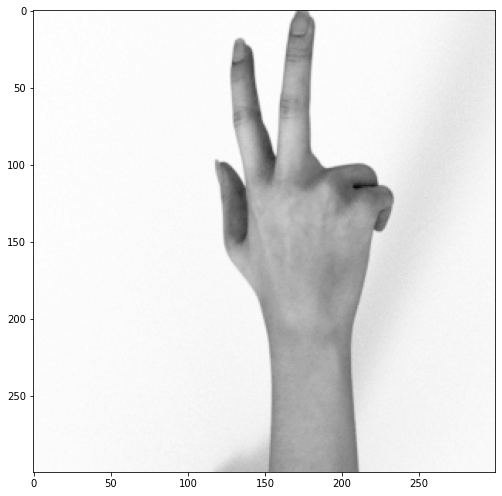

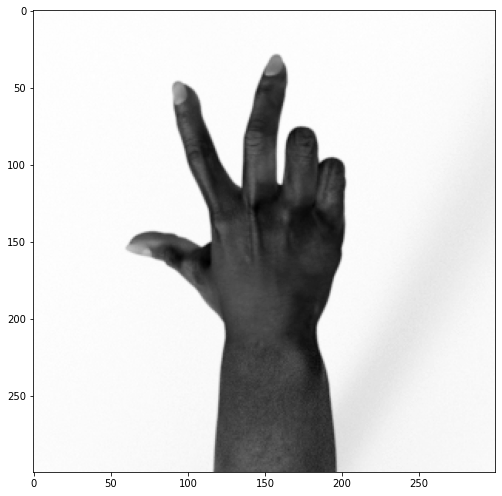

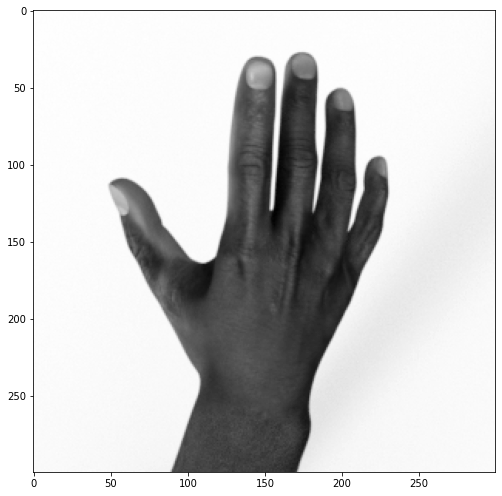

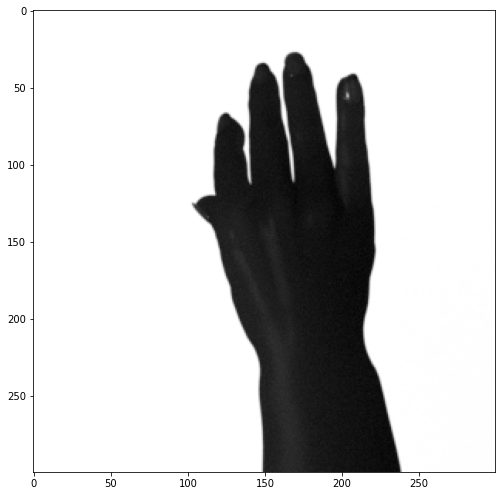

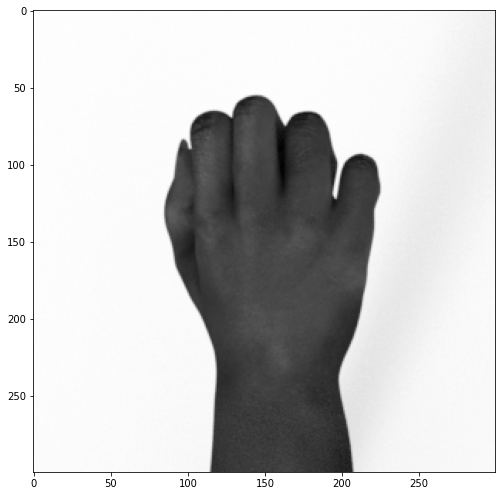

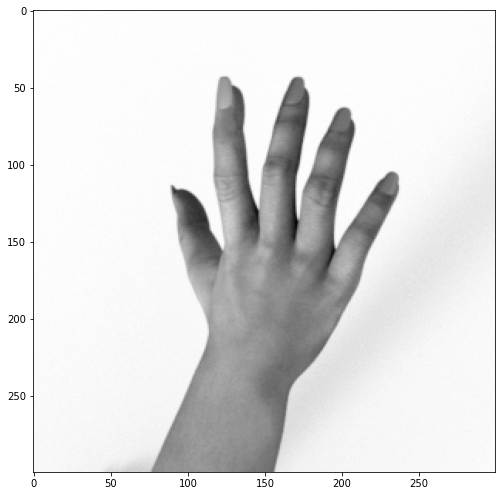

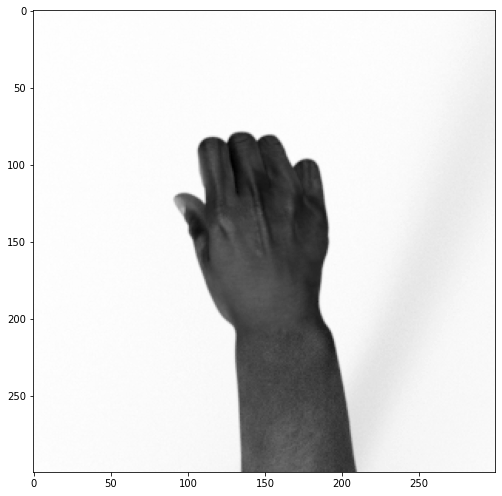

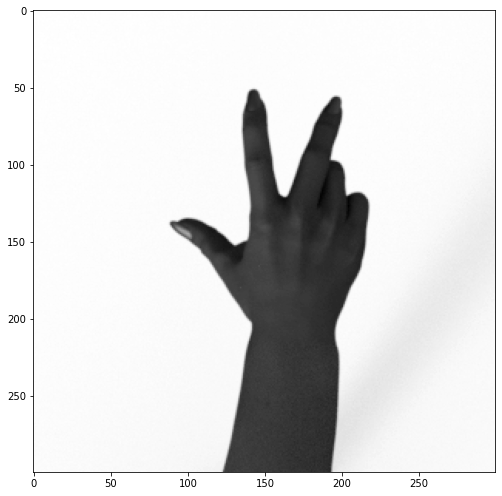

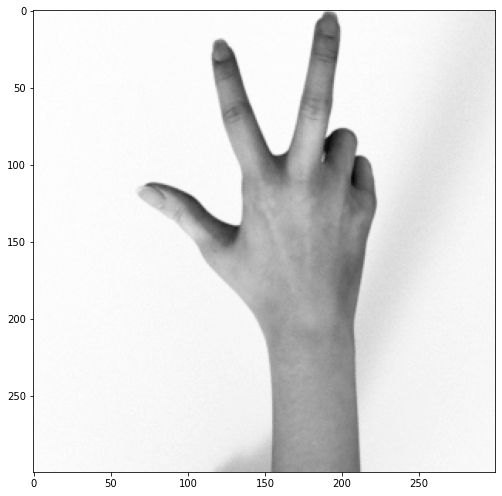

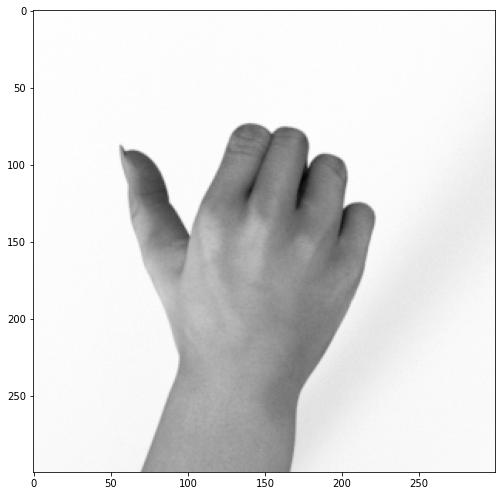

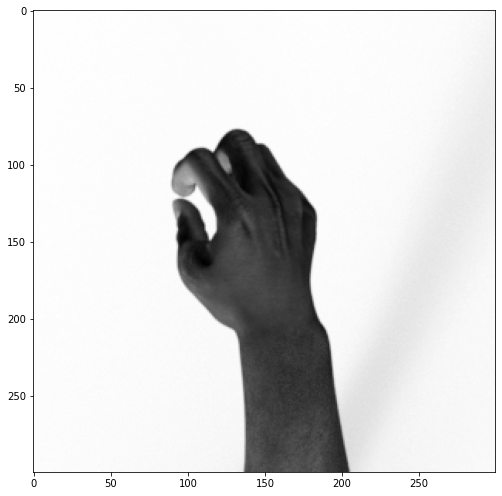

In [60]:
def plot_images(images):
    fig = plt.figure(tight_layout='auto', figsize=(20, 7))
    for i, img in enumerate(images):
        fig.add_subplot(1, len(images), i+1)
        plt.imshow(img, cmap="gray")
    return fig
    
misclass = []
i = 0
while len(misclass) <= 10 :
    if (test_predictions[i] != test_labels[i]) :
        print("Image #", i)
        print("Expected: ", test_predictions[i])
        print("Predicted: ", test_labels[i])
        print()
        misclass.append(i)
    i += 1

for j in misclass:
    plot_images(train_images[j:j+1])

pass

Your Question Responses Here

0. What is your model's accuracy on the test data?
- The model's accuracy on the test data is approximately 65%.

1. Do the misclassified examples share any similarities that you think might make them more challenging? Explain your reasoning. 
- The misclassified examples often have hand shapes that do not completely fit their category; they may have an extra finger out, a missing finger out, or the hand not being fully closed/open. Even for a human classifier such as myself, it would be difficult to classify them accurately as they do not fully fit the three labels, and so it is unsurprising that the model would also misclassify them.

2. Do you think these misclassifications could have been avoided with changes to the data collection process? Explain your reasoning. 
- Yes, because the data collection process could have eliminated images of any hands that did not fully fit the three labels, which can be considered examples of bad or ambiguous data. Ideally, after the data collection process is changed, an average human classifier should not have trouble classifying any image.

3. Do the misclassified examples surprise you and/or teach you something aboout the classification task you didn't understand at the outset? Explain your reasoning. 
- The misclassified examples surprised me because even though the images were of ambiguous shape that a human would trouble classifying, the images also tended to be of the same labels (hand not fully closed/open = paper, three fingers out = scissors, thumb out = rock). For example, images of hands with three fingers out are ambiguous (they don't fully look like scissors), but they are all labelled scissors; the model should have learned that any image of hands with two or three fingers out are scissors, yet the model still had trouble classifying them.

# Submission Instructions
Submit your completed  `Lab7.ipynb` to Gradescope. Be sure to list all of your group members in the submission!
